In [27]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import librosa
import matplotlib.pyplot as plt

# Config
DATASET_PATH = "../Voice recordings"
SAMPLE_RATE = 48000
DURATION = 2.0
N_MFCC = 10
BATCH_SIZE = 32
EPOCHS = 10
MODEL_SAVE_PATH = "cnn_model.keras"
CHUNK_FRAMES = None   # will compute dynamically after first MFCC

BLACKLIST = ["Petar"]  # because no enough data

In [28]:
# Load audio & extract MFCC
def load_audio(file_path, sr=SAMPLE_RATE):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio

# CMVN Normalization (per recording)
def cmvn_normalize(mfcc):
    mean = np.mean(mfcc, axis=0, keepdims=True)
    std = np.std(mfcc, axis=0, keepdims=True) + 1e-6
    return (mfcc - mean) / std
     
# Extract MFCC from full recording once
def extract_full_mfcc(audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # (time_steps, n_mfcc)

# Split MFCC matrix into equal sized MFCC-chunks
def split_mfcc_into_chunks(mfcc, sr=SAMPLE_RATE, duration=DURATION):
    global CHUNK_FRAMES

    # Default hop_length = 512, so mfcc_time_steps = len(audio)/(hop_length)
    hop_length = 512
    frames_per_second = sr / hop_length

    if CHUNK_FRAMES is None:
        CHUNK_FRAMES = int(frames_per_second * duration)

    chunks = []
    num_frames = mfcc.shape[0]
    num_chunks = int(np.ceil(num_frames / CHUNK_FRAMES))

    for i in range(num_chunks):
        start = i * CHUNK_FRAMES
        end = start + CHUNK_FRAMES
        chunk = mfcc[start:end]

        if len(chunk) < CHUNK_FRAMES:
            # pad MFCC frames, not raw audio
            pad_len = CHUNK_FRAMES - len(chunk)
            chunk = np.pad(chunk, ((0, pad_len), (0, 0)))

        chunks.append(chunk)
    return chunks

# Complete pipeline for one file
def process_audio_file(file_path):
    audio = load_audio(file_path)
    mfcc = extract_full_mfcc(audio)
    mfcc = cmvn_normalize(mfcc)
    mfcc_chunks = split_mfcc_into_chunks(mfcc)
    return mfcc_chunks

# Load dataset using MFCC pipeline
X = []
y = []
label_map = {}
chunks_per_speaker = {}

label_id = 0
for speaker in sorted(os.listdir(DATASET_PATH)):
    if speaker in BLACKLIST:
        print(f"Skipping blacklisted speaker: {speaker}")
        continue

    speaker_path = os.path.join(DATASET_PATH, speaker, "Train")
    if not os.path.isdir(speaker_path):
        continue

    label_map[label_id] = speaker

    for file in os.listdir(speaker_path):
        if file.endswith(".wav"):
            file_path = os.path.join(speaker_path, file)
            mfcc_chunks = process_audio_file(file_path)

            num_chunks = len(mfcc_chunks)  # Update stats
            chunks_per_speaker[speaker] = (
                chunks_per_speaker.get(speaker, 0) + num_chunks
            )

            for mfcc in mfcc_chunks:
                X.append(mfcc) 
                y.append(label_id)

    label_id += 1

X = np.array(X, dtype=object)
y = np.array(y)

max_time_steps = max([mf.shape[0] for mf in X])
X_padded = np.zeros((len(X), max_time_steps, N_MFCC))
for i, mf in enumerate(X):
    if mf.shape[0] < max_time_steps:
        X_padded[i, :mf.shape[0], :] = mf
    else:
        X_padded[i] = mf[:max_time_steps, :]

y_onehot = tf.keras.utils.to_categorical(y, num_classes=len(label_map))


Skipping blacklisted speaker: Petar



TOTAL CHUNKS PER SPEAKER
Josip: 41 chunks (total: 82.0 seconds)
Lovro: 66 chunks (total: 132.0 seconds)


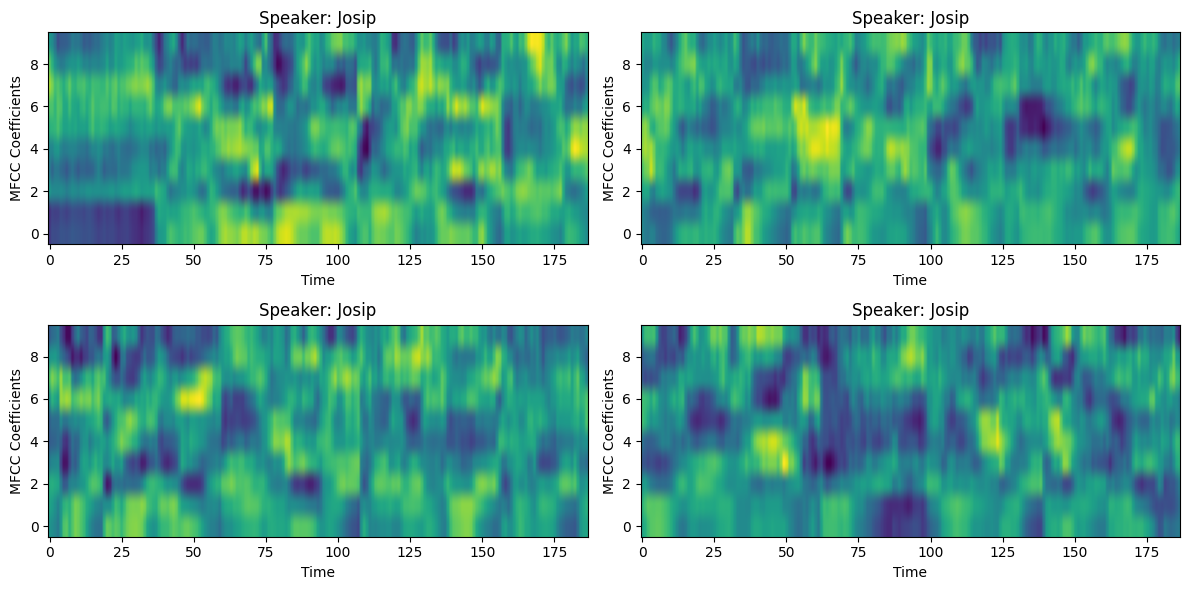

In [29]:
print("\n============================")
print("TOTAL CHUNKS PER SPEAKER")
print("============================")
for speaker, total_chunks in chunks_per_speaker.items():
    print(f"{speaker}: {total_chunks} chunks (total: {total_chunks*DURATION} seconds)")

# Visualize some MFCCs
plt.figure(figsize=(12, 6))
for i in range(min(4, len(X_padded))):
    plt.subplot(2, 2, i+1)
    plt.imshow(X_padded[i].T, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Speaker: {label_map[y[i]]}")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
plt.tight_layout()
plt.show()

In [30]:
# Build 1D-CNN model
def build_speaker_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv1D(32, kernel_size=5, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv1D(64, kernel_size=5, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.3),

        # Head
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


model = build_speaker_cnn(
    (max_time_steps, N_MFCC),
    len(label_map)
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.5294 - loss: 0.7274 - val_accuracy: 0.0909 - val_loss: 0.7416
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7882 - loss: 0.5388 - val_accuracy: 0.1818 - val_loss: 0.7689
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8824 - loss: 0.4404 - val_accuracy: 0.1818 - val_loss: 0.7882
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9294 - loss: 0.3346 - val_accuracy: 0.3182 - val_loss: 0.7744
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9412 - loss: 0.2322 - val_accuracy: 0.4545 - val_loss: 0.7183
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.1580 - val_accuracy: 0.5000 - val_loss: 0.6741
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9882 - loss: 0.1087 - val_accuracy: 0.6818 - val_loss: 0.6031
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0688 - val_accuracy: 0.7727 - val_loss: 0.5518

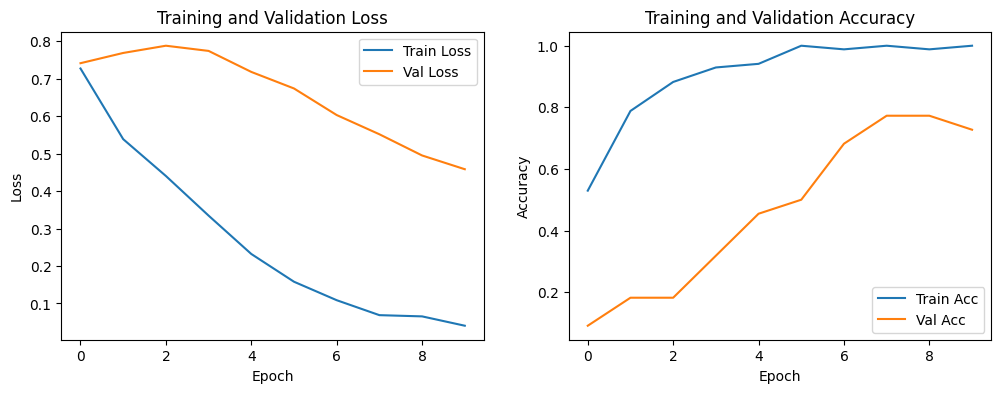

In [31]:
# -----------------------------
# Train the model
# -----------------------------
history = model.fit(X_padded, y_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

# -----------------------------
# Plot training history
# -----------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# -----------------------------
# Save Keras model
# -----------------------------
model.save(MODEL_SAVE_PATH)

In [ ]:
# -----------------------------
# Convert to TFLite with full integer quantization
# -----------------------------
def representative_dataset():
    for i in range(len(X_padded)):
        sample = X_padded[i:i+1].astype(np.float32)
        yield [sample]

converter = tf.lite.TFLiteConverter.from_saved_model("MODEL_SAVE_PATH")  # ovo jos treba debuggirat
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

# Save TFLite model
with open("speaker_cnn_model_quant.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model with quantization saved as 'speaker_cnn_model_quant.tflite'")

OSError: SavedModel file does not exist at: \{saved_model.pbtxt|saved_model.pb}